In [1]:
import os; import sys ; import matplotlib as mpl ; import matplotlib.pyplot as plt ; import numpy as np ; import csv
import pathlib; from pathlib import Path; import pandas as pd; import flopy; from flopy.utils.util_array import read1d

In [2]:
example_name = "MT3D_tutorial_08"
exe_name_mf = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf2005'
exe_name_mt = 'E:\\15_REPOS\\00_BETAMI\\bin\\mt3d-usgs_1.1.0_64'
datadir = 'E:\\15_REPOS\\00_BETAMI\\bin\\mt3dms'
output_folder = Path('ex-RES\\p08') ; output_folder.mkdir(exist_ok=True)
current_directory = os.getcwd();  print(current_directory)

E:\15_REPOS\00_BETAMI\98_Plus\02_MT3D


In [3]:
path = pathlib.Path('E:\\15_REPOS\\00_BETAMI\\98_Plus\\02_MT3D')
path.mkdir(parents=True, exist_ok=True); os.chdir(path); current_directory = os.getcwd()
directory_name = 'ex-RES'    ; workspace = os.path.join('.', directory_name)
if os.path.isdir(workspace) is False:
    os.mkdir(workspace)                         # output_folder = Path('ex-RES') ; output_folder.mkdir(exist_ok=True)

In [4]:
def p08(dirname, mixelm):
    model_ws = os.path.join(workspace, dirname)
    nlay = 27 ;nrow = 1 ;  ncol = 50 ;  delr = 5 ;  delc = 1 ;  delv = 0.25 ;  prsity = 0.35 ;  al = 0.5 ;  trpt = 0.01 ;  trpv = 0.01 ;  
    dmcoef = 1.34e-5 / 100 / 100 * 86400 ;  rech = 0.1 / 365 ;  laytyp =6*[1]+21*[0]
    perlen_mf = 1  ; perlen_mt=[5*365 ,15*365] ; k1=5e-4/100*86400;  k2=1e-2/100*86400 ; hk=k1*np.ones((nlay,nrow,ncol), dtype=float)
    hk[11:19, :, 0:24] = k2   
    hk[11:19, :,  36:] = k2  
    modelname_mf = dirname + "_mf"
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    dis = flopy.modflow.ModflowDis(mf,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,
                                   top=6.75,botm=[6.75 - delv * k for k in range(1, nlay + 1)],perlen=perlen_mf)
    f = open(os.path.join(datadir, "p08shead.dat"))  # _________________________________________________________________________________ HEADS
    strt = np.empty((nlay * ncol), dtype=float)      ; strt = read1d(f, strt).reshape((nlay, nrow, ncol))  ; f.close()
    ibound = np.ones((nlay, nrow, ncol), dtype=int)  ; ibound[5:, :, -1] = -1  ; ibound[strt < 0] = 0
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=hk, laytyp=laytyp)
    rch = flopy.modflow.ModflowRch(mf, rech=rech)
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)               ;  mf.write_input()  ; mf.run_model(silent=True)
    modelname_mt = dirname + "_mt"
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt,model_ws=model_ws,exe_name=exe_name_mt,modflowmodel=mf)
    # timprs = np.linspace(0, np.sum(perlen_mf), 100, endpoint = False) 
    btn = flopy.mt3d.Mt3dBtn(mt,icbund=1,prsity=prsity,sconc=0,nper=2,perlen=perlen_mt ,  timprs = [8 * 365, 12 * 365, 20 * 365] )  # = timprs  
#   flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)   ________ Stress periods __________________________ MF5
    percel = 1.0  ; itrack = 3  ; wd = 0.5  ; dceps = 1.0e-5  ; nplane = 0  ; npl = 0  ;  nph = 10  ; npmin = 2   
    npmax = 20  ; dchmoc = 1.0e-3  ; nlsink = nplane  ; npsink = nph   
    adv = flopy.mt3d.Mt3dAdv(mt,mixelm=mixelm,dceps=dceps,nplane=nplane,npl=npl,nph=nph,npmin=npmin,npmax=npmax,nlsink=nlsink,
                             npsink=npsink,percel=percel,itrack=itrack,wd=wd)
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt, trpv=trpv, dmcoef=dmcoef)
    crch1 = np.zeros((nrow, ncol), dtype=float)          ;   crch1[0, 9:18] = 1.0           
    cnc0 = [(0, 0, j, 1  , -1)   for j in range(8, 16)]
    cnc1 = [(0, 0, j, 0.0, -1)   for j in range(8, 16)]  ; ssmspd = {0: cnc0, 1: cnc1}
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data = ssmspd)                             # ___  Setup constant concentration SSMSPD (MF5)
    gcg = flopy.mt3d.Mt3dGcg(mt)                               ; mt.write_input()
    fname = os.path.join(model_ws, "MT3D001.UCN")
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    fname = os.path.join(model_ws, "MT3D001.UCN") ; ucnobj=flopy.utils.UcnFile(fname)  ;times=ucnobj.get_times()  ;conc=ucnobj.get_alldata()
    fname = os.path.join(model_ws, "MT3D001.OBS")
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None
    fname = os.path.join(model_ws, "MT3D001.MAS") ; mvt = mt.load_mas(fname)
    return mf, mt, conc, cvt, mvt, times

found 'rch' in modflow model, resetting crch to 0.0


Text(0.5, 1.0, '__________________20 ')

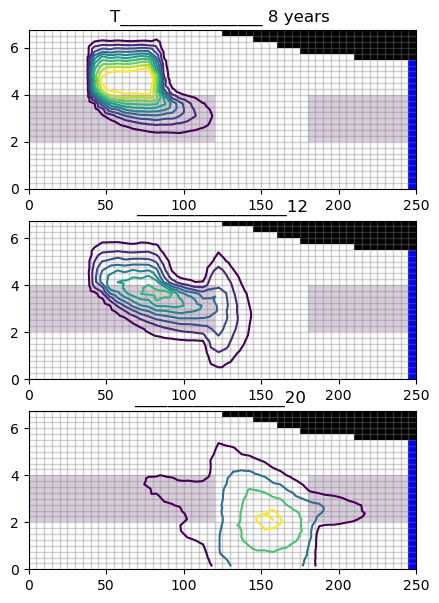

In [5]:
mf, mt, conc, cvt, mvt, times = p08("p08", 3)      
hk = mf.lpf.hk.array                        ; fig = plt.figure(figsize=(5, 7))                  ; ax = fig.add_subplot(3, 1, 1)    

mx = flopy.plot.PlotCrossSection(ax=ax, model=mf, line={"row": 0})
mx.plot_array(hk , masked_values = [hk[0, 0, 0]], alpha=0.2)     
mx.plot_ibound() ; mx.plot_grid    (color="0.5" , alpha=0.2)
cs = mx.contour_array(conc[1], levels=np.arange(0.05, 0.55, 0.05), masked_values=[1.0e30])      ; ax.set_title("T_________________ 8 years ")

ax = fig.add_subplot(3, 1, 2)   
mx = flopy.plot.PlotCrossSection(ax=ax, model=mf, line={"row": 0})
mx.plot_array(hk , masked_values = [hk[0, 0, 0]], alpha=0.2)     
mx.plot_ibound() ; mx.plot_grid    (color="0.5" , alpha=0.2)
cs = mx.contour_array(conc[2], levels=np.arange(0.05, 0.55, 0.05), masked_values=[1.0e30]) ; ax.set_title("__________________12")

ax = fig.add_subplot(3, 1, 3)  
mx = flopy.plot.PlotCrossSection(ax=ax, model=mf, line={"row": 0})
mx.plot_array(hk , masked_values = [hk[0, 0, 0]], alpha=0.2)     
mx.plot_ibound() ; mx.plot_grid    (color="0.5" , alpha=0.2)
cs = mx.contour_array(conc[3], levels=[0.05, 0.1, 0.15, 0.19], masked_values=[1.0e30])     ; ax.set_title("__________________20 ")

In [6]:
print(conc.shape),  type(conc)

(4, 27, 1, 50)


(None, numpy.ndarray)

In [7]:
perlen_mf = 1  ; perlen_mt=[5*365 ,15*365] ; nprs = 100
timprs = np.linspace(0, np.sum(perlen_mt), nprs, endpoint = False) # timprs

In [8]:
fname = os.path.join(output_folder,'MT3D001.UCN')    #  ; fname    
ucnobj = flopy.utils.UcnFile(fname)        ; conc = ucnobj.get_alldata()   ; ttimes = ucnobj.get_times()   # print('conc_MF5', conc.shape) 
conc2=conc[:,0,:,:]
save = conc.reshape(conc.shape[0],-1)  ;  then=pd.DataFrame(save)  ; then.to_csv(output_folder/'a1_C(x,y).csv')   # timprs=True

In [9]:
with open(output_folder/'A.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
    A = pd.DataFrame(csvFile)    